# *Customer Segmentation*

## Introduction

More often than not, i've been asked "Hey Ian, i would like know how good are our new customers, are they spending as much money on our product as we'd originally thought they would?" or in the case of telco industry, "How often are our roamers travelling?". There are probably a number of thoughts going through your head right now as to ways in which you should or can slice and dice data to have a clearer picture. I found this course about [*Customer Segmentation in Python*](https://www.datacamp.com/courses/customer-segmentation-in-python) by Karolis Urbonas on Data camp that i think is really useful for the future. It uses a dataset from UCI Machine Learning Repository. Depending on what questions you are trying to answer, you can use this as a guiding framework. This notebook is split into 2 major sections, the first one will be going through *cohort analysis* and the second one will be going through *clustering*.


1. Cohort Analysis
    * 1.1. [Loading data sets and packages](#t1.1)
    * 1.2. [Data wrangling](#t1.2)
    * 1.3. [Getting cohorts](#t1.3)
    * 1.4. [Visualizing cohorts](#t1.4)
    * 1.5. [RFM (Recency, Frequency, Monetary)](#t1.5)
    * 1.6. [Percentile and labelling](#t1.6)
    * 1.7. [Analyzing customer segments - RFM](#t1.7)

2. Clustering
    * 2.1. [Preprocessing](#t2.1)
    * 2.2. [Center and Scaling](#t2.2)
    * 2.3. [Implementation of K-means clustering](#t2.3)
    * 2.4. [Customer personas analysis](#t2.4)
3. [Weakness in KMeans](#t3)
    

<a id="t1.1"></a>
#### 1.1. Loading data sets and packages

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
dateCols = ['InvoiceDate']
online = pd.read_csv('online.csv', parse_dates = dateCols) 

# Double checking the date column is loaded as dates
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 9 columns):
Unnamed: 0     70864 non-null int64
InvoiceNo      70864 non-null int64
StockCode      70864 non-null object
Description    70864 non-null object
Quantity       70864 non-null int64
InvoiceDate    70864 non-null datetime64[ns]
UnitPrice      70864 non-null float64
CustomerID     70864 non-null int64
Country        70864 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.9+ MB


<a id="t1.2"></a>
#### 1.2. Data wrangling

In [2]:
# this function is to get the first day of the month
def get_month(x):
    return dt.date(x.year, x.month,1)

# after getting the month from invoice date, i convert it to datetime format
online['InvoiceMonth'] = pd.to_datetime(online['InvoiceDate'].apply(get_month))

# checking the format the invoicemonth
#online.info()

In [3]:
# Need to group by customer id and invoice month in order to work out when was the first purchase day as we 
#define that as the start of the cohort
grouping = online.groupby('CustomerID')['InvoiceMonth']

# to get the first transaction month
online['CohortMonth'] = grouping.transform('min')

# customer 14286's first purchase was made on 2011-04-11, lets filter for the customer and have a look at their transaction 
# just a sanity check
#online.loc[online['CustomerID'] == 14286].sort_values('InvoiceDate')


In [4]:
# define a function to extract the individual year, month and day integer values
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.month
    return year, month, day

# getting the respective year and month, days can be ignored as we are not using it
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortMonth')

# to work out the difference in time between the first transaction made and the current transaction
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day


<a id="t1.3"></a>
#### 1.3. Getting cohorts

In [5]:
# Extract the difference in months from all previous values
online['CohortIndex'] = years_diff*12 + months_diff + 1
online.head(n=3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1


In [6]:
#in order to see retention, we need to group by cohort
grouping = online.groupby(['CohortMonth','CohortIndex'])

# Depending on what metric you are after, you should group by different things ie customer id for counting unique or average price per product
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique) #its in series format after grouping, hence need to reset index
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date # i had to do this get rid of the time on the datetime
#cohort_data.info() # back in dataframe format
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                  columns = 'CohortIndex',
                                  values = 'CustomerID')


In [7]:
# store first column as cohort sizes because we need to divide the rest of the columnds by the first column
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Converting the values into percentage
#retention.info()

<a id="t1.4"></a>
#### 1.4.Visualizing Cohorts

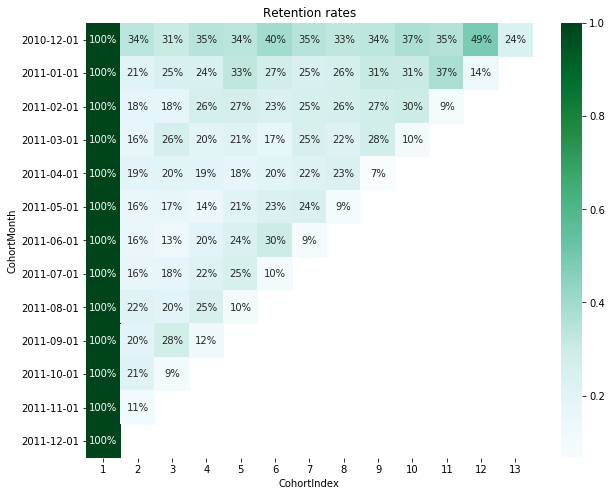

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(data = retention,
           annot=True,
           fmt = '.0%',
           cmap = 'BuGn')
plt.title('Retention rates')
plt.show()

<a id="t1.5"></a>
#### 1.5. RFM (Recency, Frequency, Monetary Value)

* Recency (R)
 * days since last customer transaction
* Frequency (F)
 * number of transactions in the last 12 months
* Monetary Value (M)
 * total spend in the last 12 months
 RFM values can be grouped in several ways
 * Percentiles eg quantiles
 * Pareto 80/20 cut
 * Custom - based on business knowledge
 1. Sort customers based on that metric
 2. Break customers into a pre-defined number of groups of equal size
 3. assign a label to each group
 Assign labels
 * Highest score to the best metric - best is not always highest eg recency
 
 

In [9]:
# prep data for RFM
# confirm dataframe with only the latest 12 months
print('Min:{}; Max:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:49:00


In [10]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days = 1)

In [11]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

In [12]:
datamart = online.groupby(['CustomerID']).agg({
                                                'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                                'InvoiceNo': 'count',
                                                'TotalSum': 'sum'
                                            })
# renaming the datamart
datamart.rename(columns = {'InvoiceDate': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'TotalSum': 'MonetaryValue'}, inplace = True)
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


<a id="t1.6"></a>
#### 1.6. Percentile and labelling

In [13]:
# create labels for recency and frequency
r_labels = range(3,0,-1)
f_labels = range(1,4)

# Assign these labels to three equal percentile groups
r_groups = pd.qcut(datamart['Recency'], q=3, labels = r_labels)

# assign these labels to three equal percentile groups
f_groups = pd.qcut(datamart['Frequency'], q=3, labels = f_labels)

# create new columns R and F
datamart = datamart.assign(R = r_groups.values, F = f_groups.values)

#create labels for monetary value
m_labels = range(1,4)

# assign these labels to three equal percentile groups
m_groups = pd.qcut(datamart['MonetaryValue'], q = 3, labels = m_labels)

# create new column M
datamart = datamart.assign(M=m_groups.values)

# calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis = 1)
print(datamart['RFM_Score'].head())

CustomerID
12747    9.0
12748    9.0
12749    9.0
12820    9.0
12822    6.0
Name: RFM_Score, dtype: float64


<a id="t1.7"></a>
#### 1.7. Analyzing customer segments - RFM

In [14]:
# creating custom segments
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] > 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'
    
# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis = 1)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12747,2,27,992.82,3,3,3,9.0,Middle
12748,1,967,7522.06,3,3,3,9.0,Middle
12749,4,37,813.45,3,3,3,9.0,Middle
12820,3,17,268.02,3,3,3,9.0,Middle
12822,71,9,146.15,2,2,2,6.0,Low



#### Analyzing customer segments

In [15]:
# Analyzing custom segments
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1)

rfm_level_agg

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         139.2       6.0         109.0  2170
Middle       30.7      37.8         765.4  1531

## 2. KMeans Clustering 
`sklearn.cluster.KMeans` [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

<a id="t2.1"></a>
### 2.1. Preprocessing data 
* symmetric distribution of variables (not skewed)
* variables with the same mean values
* variables with same variance
* skew can be removed with logarithmic transformation  [(visualizing log transformation)](http://onlinestatbook.com/2/transformations/log.html)
* k means assumes equal mean and equal variance

[Why bother preprocessing our data before KMeans clustering?](https://www.edupristine.com/blog/k-means-algorithm)

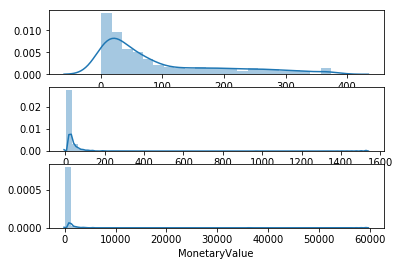

In [16]:
# explore the skewness of data
plt.subplot(3,1,1);sns.distplot(datamart['Recency'])
plt.subplot(3,1,2);sns.distplot(datamart['Frequency'])
plt.subplot(3,1,3);sns.distplot(datamart['MonetaryValue'])

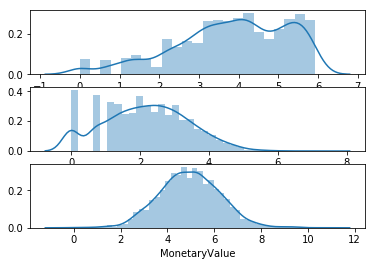

In [17]:
# log transform the skewness of data 
plt.subplot(3,1,1);sns.distplot(np.log(datamart['Recency']))
plt.subplot(3,1,2);sns.distplot(np.log(datamart['Frequency']))
plt.subplot(3,1,3);sns.distplot(np.log(datamart['MonetaryValue']))

<a id="t2.2"></a>
### 2.2. Centre and Scaling
K-means works best on variables with the same mean, so we must first identify the issue and compare variable's mean and standard deviation <br>
**Centering** can be done by substracting average value from each observation <br>
**Scaling** can be done by dividing them by standard deviation of each

In [18]:
# lets try to do it manually but theres a much simpler way
recency_center = datamart['Recency'] - datamart['Recency'].mean() 

recency_scale = datamart['Recency'] / datamart['Recency'].std()

recency_normalized = (datamart['Recency'] - datamart['Recency'].mean()) / datamart['Recency'].std()
recency_normalized.describe().round(2)

count    3701.00
mean       -0.00
std         1.00
min        -0.93
25%        -0.75
50%        -0.42
75%         0.57
max         2.80
Name: Recency, dtype: float64

The *sequence* in which we transform and scale is important due to the following reasons:
* log transmation only works with positive data [(stackexchange)](https://stats.stackexchange.com/questions/155429/how-to-transform-negative-values-to-logarithms)
* normalization forces data to have negative values and log will not work 

**Steps** to unskew and scale:
1. Unskew the data - log transformation
2. standardize to the same average values
3. scale to the same standard deviation
4. store as a separate array to be used for clustering (need original data to calculate statistics)

In [19]:
datamart_rfm = datamart.iloc[:,0:3]
#unskew data
datamart_log = np.log(datamart_rfm)
# initialize standard scaler
scaler = StandardScaler()
scaler.fit(datamart_log)

# scale and center data
datamart_normalized = scaler.transform(datamart_log)

#create a pandas dataframe
datamart_normalized = pd.DataFrame(data = datamart_normalized, index = datamart_rfm.index, columns= datamart_rfm.columns)

<a id="t2.3"></a>
### 2.3. Implementation of K-means clustering
How many clusters should we be building our K-means on? Well, there is no hard and fast rule and we should always experiment with different clusters, as well as visually checking them!

* 2.3.1 choosing a number of clusters
* 2.3.2 running k-means clustering on pre-processed data
* 2.3.3 analyzing average RFM values of each cluster

#### 2.3.1 Choosing number of clusters
* Visual methods - elbow criterion
    * plot the number of clusters against within-cluster sum of squared errors
    * identify an 'elbow' in the plot
    * elbow - a point representing an 'optimal' number of clusters
    * best to choose the point on elbow
    * use as a guide but test multiple solutions
    * analyze their properties - average RFM values
    * compare against each other and choose one which makes most business sense
* mathematical methods - silhouette coefficient [sklearn documentation for silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
* experimentation and interpretation

In [20]:
# Fit Kmeans and calculate SSE for each K
from sklearn.cluster import KMeans
sse = {}
for k in range(1,21):
    
    #Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters = k, random_state=1)
    
    #Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    #Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

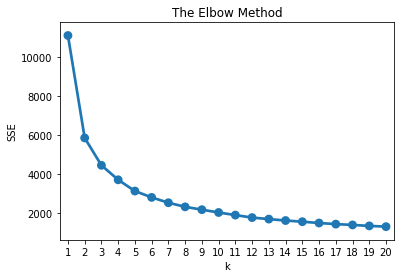

In [21]:
# add the plot title 'the elbow method'
plt.title('The Elbow Method')

# add x-axis label K
plt.xlabel('k')

# add y-axis label 'sse'
plt.ylabel('SSE')

# plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.show()

#### 2.3.2 Running K-means clustering on preprocessed data

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 1)

kmeans.fit(datamart_normalized)

#extracting cluster labels
cluster_labels = kmeans.labels_

# getting the sum of squared distances
kmeans.inertia_

4457.000273214813

#### 2.3.3 Analyzing average RFM values for each cluster

In [23]:
# Create a dataframe by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)

datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(1)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          78.4      13.6         232.0  1621
1         171.6       3.1          55.3  1225
2          13.8      52.7        1128.1   855

#### 2.3.4 Visualizing the cohorts
Visualizing anything more than 2 features is a problem. However, this obstacle can be resolved via PCA or t-SNE, where those algorithms takes a high dimention dataset and reduces to a lower number of features whilst preserving as much information/variance as possible. I'll explore PCA in more detail in another notebook.

[In Depth: Principal Component Analysis by *Jake Vanderplas*](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) 

These are some youtube videos worth a watch if you have a few minutes to spare.<br>
[StatQuest: t-SNE clearly explained](https://www.youtube.com/watch?v=NEaUSP4YerM)<br>
[StatQuest: PCA step by step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

<a id="t2.4"></a>
### 2.4. Customer personas analysis
Communication is the key to success in any data science project. The ability to explain concepts in a simple manner that be understood by management is utmost important and should never be neglected!

#### 2.4.1 Snake plots to understand and compare segments
* market reseach technique to compare different segments
* visual representation of each segment attributes
* need to first normalize data (center * scale)
* plot each cluster's average normalized values of each attribute

In [24]:
# prepare data for snake plot by melting the dataset
datamart_melt = pd.melt(
                        datamart_rfm_k3.reset_index(),
                        id_vars = ['CustomerID','Cluster'],
                        value_vars = ['Recency','Frequency','MonetaryValue'],
                        var_name = 'Metric', value_name = 'Value')


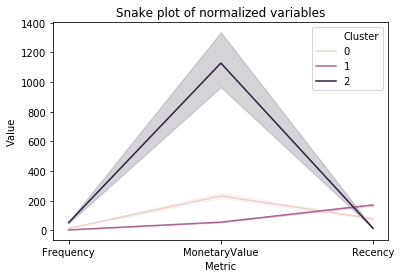

In [25]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data = datamart_melt, x = 'Metric', y = 'Value', hue = 'Cluster')
plt.show()

#### 2.4.2 Relative importance of segment attributes
* useful technique to identify relative importance of each segment's attribute
* calculate average values of each cluster
* calculate average values of population
* calculate importance score by dividing them and subtracting 1 -> avg(cluster)/avg(population) - 1
* compare the averages of the profiling variables of each segment relative to the average of the variables across the whole population. (if all segments are much like the overall population, then there may not be any segments at all)

Analyze and plot relative importance 
* the further a ratio is from 0, the more important that attribute is for a segment relative to the total population
* plot a heatmap for easier interpretation

In [26]:
# calculate relative importance of each attribute

# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# calculate relative importance of cluster's attribute value compared to population
# why minus 1? i dont get it
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.17      -0.29          -0.39
1           0.82      -0.84          -0.85
2          -0.85       1.75           1.96


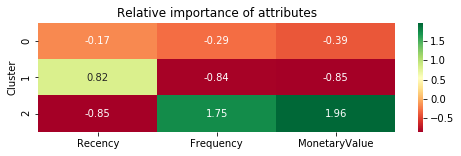

In [27]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data = relative_imp, annot = True, fmt='.2f',cmap = 'RdYlGn')

<a id="t3"></a>
## 3. Weakness in KMeans
k-Means is by no means bullet proof and it definitely has its weaknesses. I will not dive into this issue in this notebook but it'll have to be looked into in future at some point. *Jake VanderPlas* has written extensively on this topic ['Gaussian Mixture Model'](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) so it's definitely worth spending some time on it.

Quality materials found during the write up <br>
[Cluster Analysis and Segmentation by *T. Evgeniou*](https://inseaddataanalytics.github.io/INSEADAnalytics/CourseSessions/Sessions45/ClusterAnalysisReading.html) <br>
[K-means clustering is not a free lunch by *David Robinson*](http://varianceexplained.org/r/kmeans-free-lunch/) <br>
[Python Data Science Handbook - In Depth: k-Means Clustering by *Jake VanderPlas*](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)